In [1]:
# Need to do this before importing RV when running in a Docker container from VS Code.
# This has to do with the fact that VS Code is not setting env vars in the notebook correctly.
import os
os.environ['GDAL_DATA'] = '/opt/conda/lib/python3.7/site-packages/rasterio/gdal_data/'

In [2]:
from os.path import join

import matplotlib.pyplot as plt

from rastervision.pytorch_learner.dataset import (
    SemanticSegmentationSlidingWindowGeoDataset, 
    ObjectDetectionSlidingWindowGeoDataset,
    ClassificationSlidingWindowGeoDataset, 
    object_detection_tuple_to_boxlist)
from rastervision.pytorch_learner.visualizer import (
    SemanticSegmentationVisualizer, 
    ObjectDetectionVisualizer,
    ClassificationVisualizer)
from rastervision.core.data import ClassConfig

In [5]:
class_names = ['Building', 'Background']
class_colors = ['orange', 'black']
building_id = 0
background_id = 1
chip_sz = 300
chip_stride = chip_sz // 2
class_config = ClassConfig(names=class_names)
channel_order = [0, 1, 2, 3]
channel_display_groups = {'RGB': (0, 1, 2), 'IR': (3, )}

root_uri = '/opt/data/spacenet-sample'
image_uri = join(root_uri, 'SN2_buildings_train_AOI_5_Khartoum_PS-MS_img1003.tiff')
label_uri = join(
    root_uri, 'SN2_buildings_train_AOI_5_Khartoum_geojson_buildings_img1003.geojson')
scene_id = '1003'    

In [ ]:
# TODO show whole scene

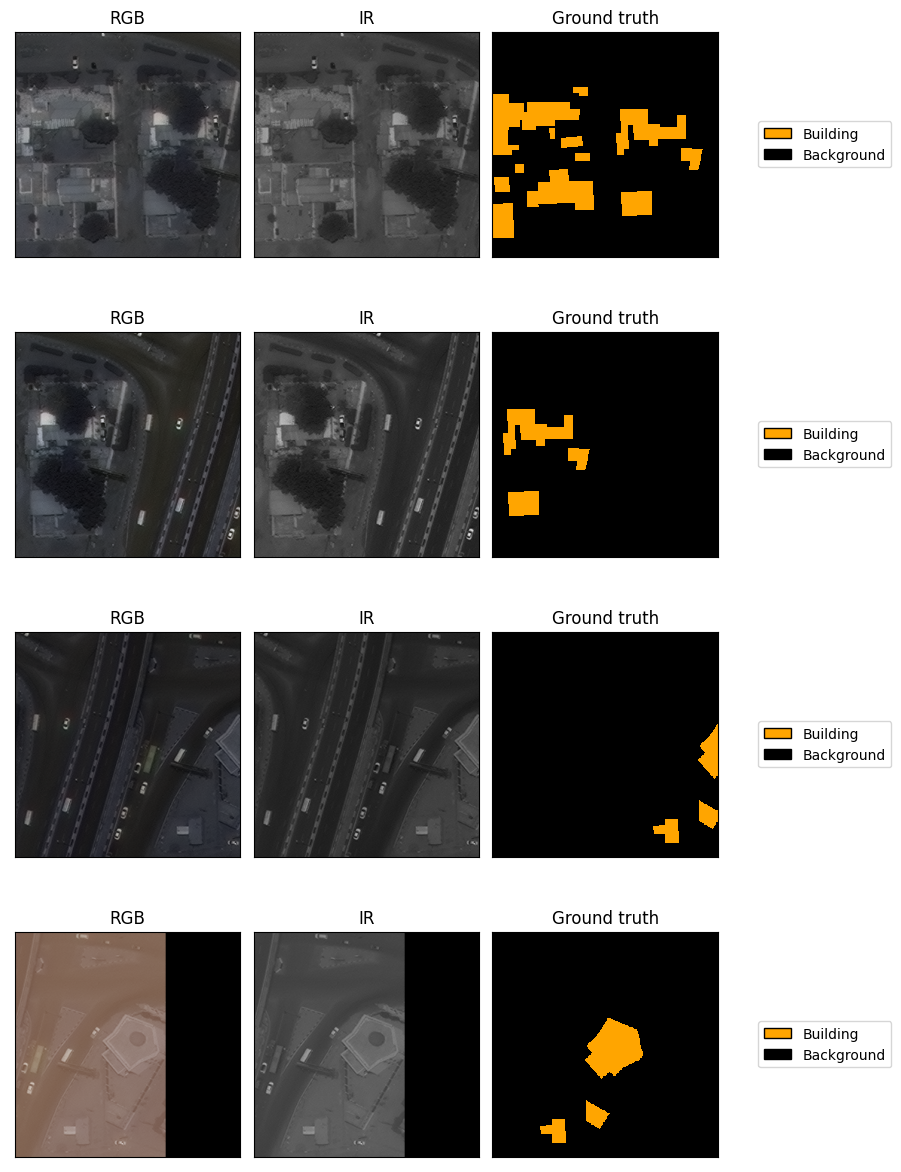

In [4]:
ds = SemanticSegmentationSlidingWindowGeoDataset.from_uris(
    class_config=class_config,
    image_uri=image_uri,
    label_vector_uri=label_uri,
    size=chip_sz,
    stride=chip_stride,
    label_vector_default_class_id=building_id,
    label_raster_source_kw={'background_class_id': background_id})
    
vis = SemanticSegmentationVisualizer(
    class_names=class_names, class_colors=class_colors,
    channel_display_groups=channel_display_groups)
x, y = vis.get_batch(ds, 4)
vis.plot_batch(x, y, show=True)

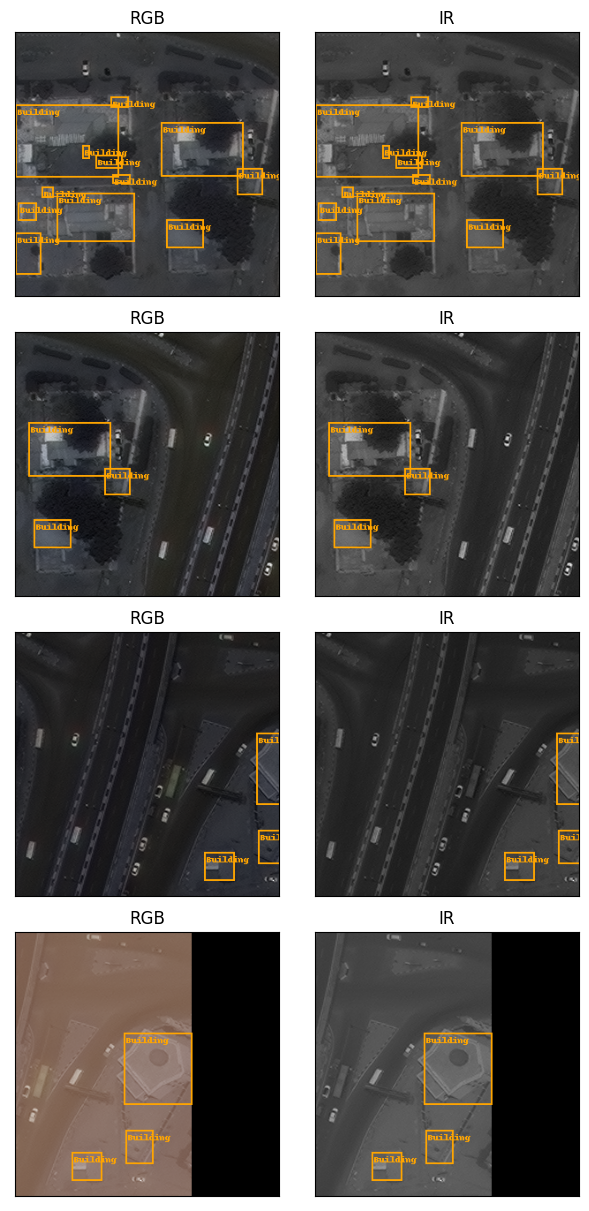

In [14]:
"""
if you don't set label_vector_default_class_id, it will filter out all the ids
this is one reason not to use from_uris. It's easier to shoot yourself in the foot. 
You also don't have the type system guiding you like you do when building Config objects
compositionally. also it's hard to know that size and stride should be passed when it's
just captured by kwargs.
"""

"""
When you create a `GeoDataset` directly without use of `LearnerConfig`,
a transform is not set. But, `object_detection_transformer` does not 
convert to `BoxList` when transform is set to None. This is a problem because
`Visualizer` (and previously `Learner`), expects it to be in `BoxList` format.
Can we make `object_detection_transformer` always convert to `BoxList`?
"""
ds = ObjectDetectionSlidingWindowGeoDataset.from_uris(
    class_config=class_config,
    image_uri=image_uri,
    label_vector_uri=label_uri,
    size=chip_sz,
    stride=chip_stride,
    label_vector_default_class_id=building_id,
    image_raster_source_kw={'channel_order': channel_order})

vis = ObjectDetectionVisualizer(
    class_names=class_names, class_colors=class_colors,
    channel_display_groups=channel_display_groups)
x, y = vis.get_batch(ds, 4)
# TODO make dataset return boxlist even if no transform is set
# what is a good standard format?
y = [object_detection_tuple_to_boxlist(_y) for _y in y]
vis.plot_batch(x, y, show=True)

Inferring labels
Inferring labels


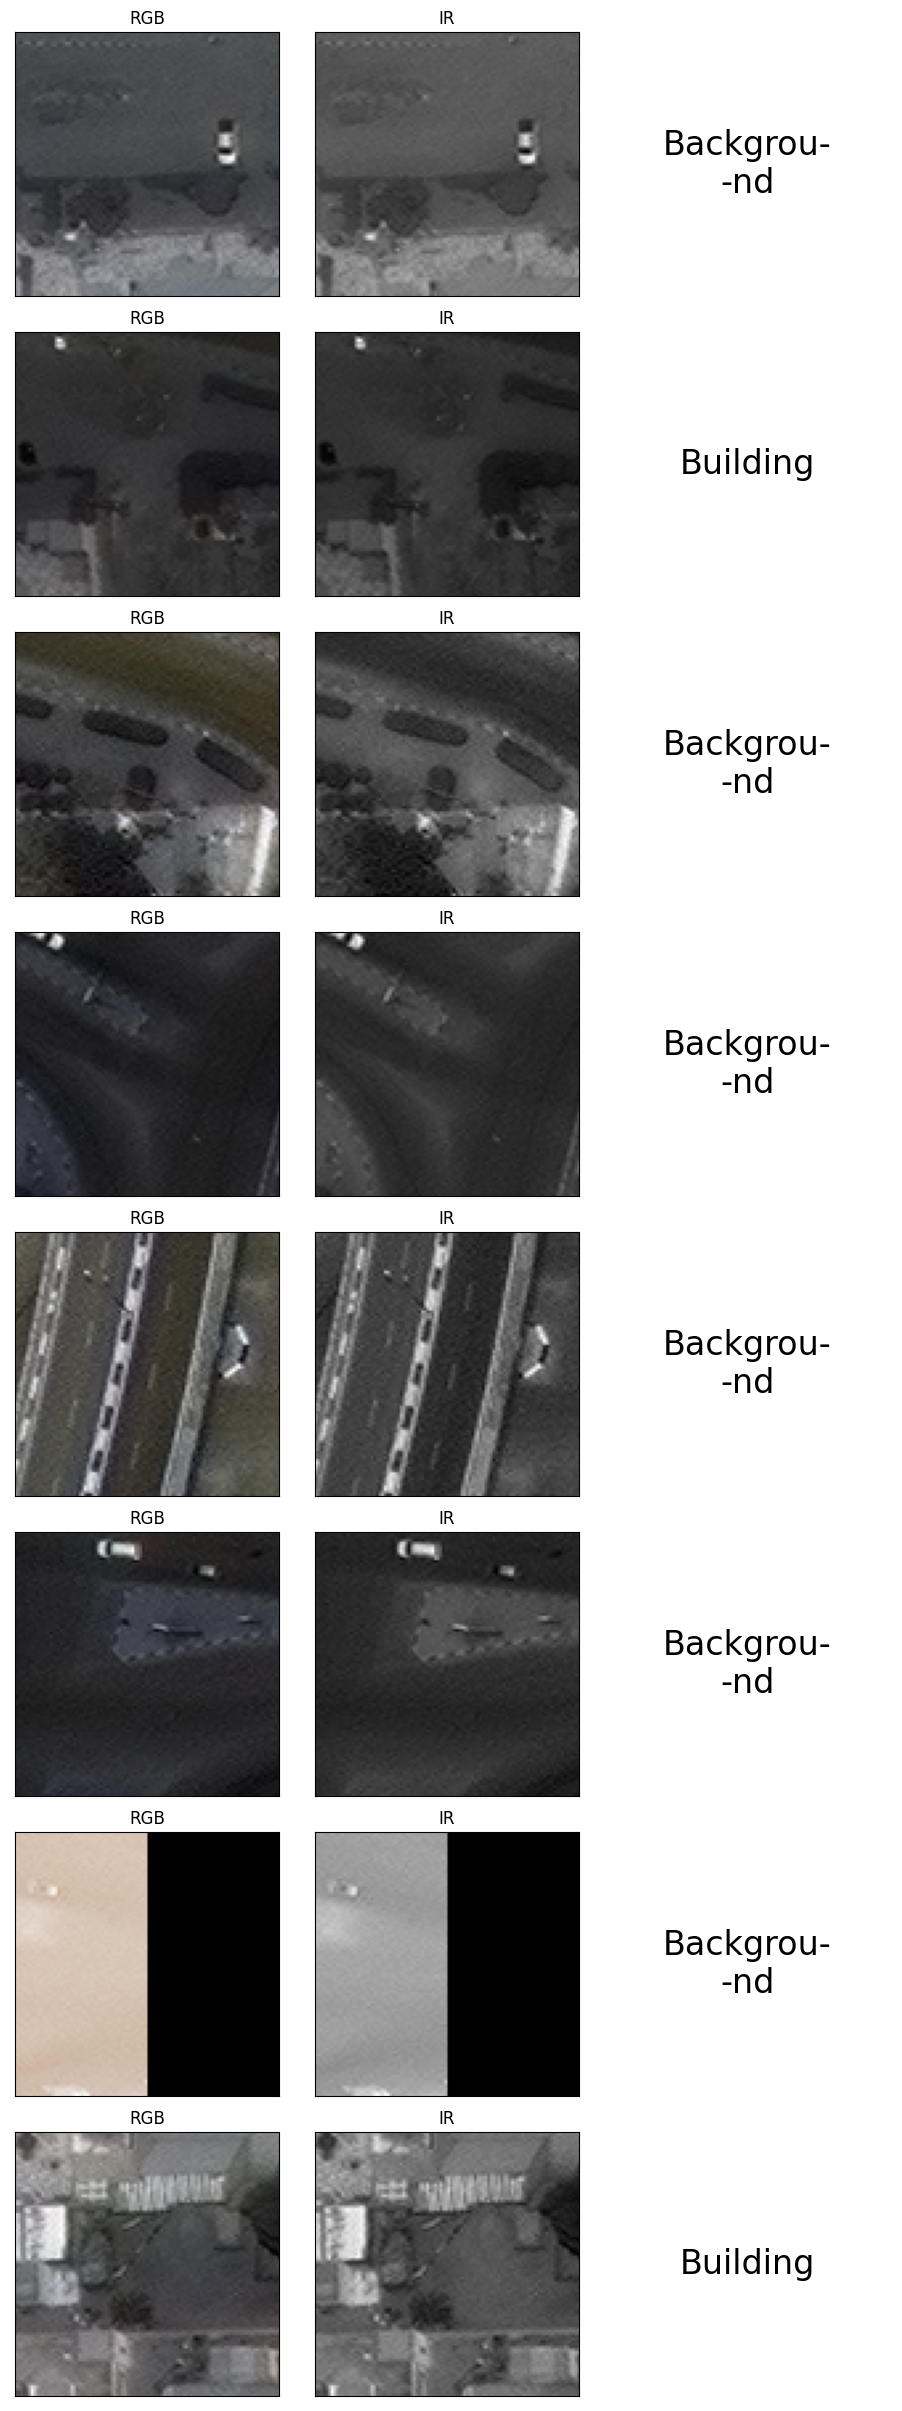

In [6]:
ds = ClassificationSlidingWindowGeoDataset.from_uris(
    class_config=class_config,
    image_uri=image_uri,
    label_vector_uri=label_uri,
    label_vector_default_class_id=building_id,
    size=100,
    stride=100,
    label_source_kw={
        'ioa_thresh': 0.5,
        'use_intersection_over_cell': False,
        'pick_min_class_id': False,
        'background_class_id': background_id,
        'infer_cells': True,
        'cell_sz': 100
    })
vis = ClassificationVisualizer(
    class_names=class_names, class_colors=class_colors,
    channel_display_groups=channel_display_groups)
x, y = vis.get_batch(ds, 8)
vis.plot_batch(x, y, show=True)